In [1]:
# Leave commented out if already done
# pip install Pillow
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

2022-12-03 20:13:56.847761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
IMAGE_SIZE = [176,208]               # input image dimensions                                              (176,208)
BATCH_SIZE = 5000
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.01                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
EPOCHS = 50                     # number of epochs to run                                             50
#momentum = .9                 # momentum of SGD                                                     .9

In [3]:

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory="/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/train/",target_size=IMAGE_SIZE,
                                              batch_size=BATCH_SIZE)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory="/kaggle/input/dataset-alzheimer/Alzheimer_s Dataset/test",target_size=IMAGE_SIZE,batch_size=BATCH_SIZE,
                                           shuffle = False) # test data should not be shuffle

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [5]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(6279, 176, 208, 3)
(6279, 4)


In [6]:
initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (4395, 176, 208, 3)
validation (628, 176, 208, 3)
test (1256, 176, 208, 3)


In [7]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4395, 176, 208, 3)
(4395, 4)
(628, 176, 208, 3)
(628, 4)
(1256, 176, 208, 3)
(1256, 4)


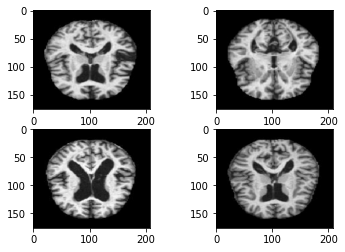

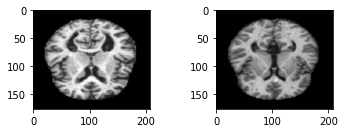

In [8]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [9]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


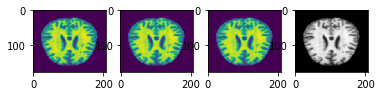

In [10]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [11]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        #tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [12]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [13]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        #tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [14]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='auc')]

    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

2022-12-03 20:15:31.803464: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-03 20:15:31.809703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-03 20:15:31.917807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 20:15:31.918644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-12-03 20:15:31.918830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-0

In [15]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [16]:
model_history = model.fit(train_data,train_labels,validation_data=(val_data,val_labels),
                             epochs=EPOCHS,batch_size=batch, shuffle=True) 
#scores = model.evaluate(train_data, train_labels)
#print("Accuracy: %.2f%%" %(scores[-1]*100))

2022-12-03 20:15:36.234786: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1930705920 exceeds 10% of free system memory.
2022-12-03 20:15:37.936804: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-03 20:15:37.959714: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


Epoch 1/50


2022-12-03 20:15:40.650080: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-03 20:15:42.698397: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-03 20:15:42.771474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


220/220 [==============================] - ETA: 0s - loss: 1.7102 - accuracy: 0.7089 - precision: 0.3668 - recall: 0.2240 - auc: 0.5901

2022-12-03 20:16:11.230555: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 275877888 exceeds 10% of free system memory.


220/220 [==============================] - 35s 84ms/step - loss: 1.7093 - accuracy: 0.7090 - precision: 0.3670 - recall: 0.2241 - auc: 0.5903 - val_loss: 1.2495 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7335
Epoch 2/50
220/220 [==============================] - 16s 75ms/step - loss: 1.2094 - accuracy: 0.7552 - precision: 0.5168 - recall: 0.3205 - auc: 0.7433 - val_loss: 1.0824 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7268
Epoch 3/50
220/220 [==============================] - 17s 76ms/step - loss: 1.1438 - accuracy: 0.7484 - precision: 0.4945 - recall: 0.2793 - auc: 0.7586 - val_loss: 1.2103 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6286
Epoch 4/50
220/220 [==============================] - 17s 76ms/step - loss: 1.0443 - accuracy: 0.7753 - precision: 0.5930 - recall: 0.3228 - auc: 0.7949 - val_loss: 1.1866 - val_accuracy: 0.7520 - val_precision: 1

In [17]:
pred_labels = model.predict(test_data)

2022-12-03 20:30:17.967380: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 551755776 exceeds 10% of free system memory.


In [18]:
_ = model.evaluate(test_data, test_labels)

 3/40 [=>............................] - ETA: 1s - loss: 0.5841 - accuracy: 0.9167 - precision: 0.8333 - recall: 0.8333 - auc: 0.9608

2022-12-03 20:30:25.375764: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 551755776 exceeds 10% of free system memory.


40/40 [==============================] - 1s 21ms/step - loss: 0.4200 - accuracy: 0.9305 - precision: 0.8625 - recall: 0.8591 - auc: 0.9733


In [19]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 208, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 208, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 104, 16)       0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 52, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 26, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 13, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 13, 128)      

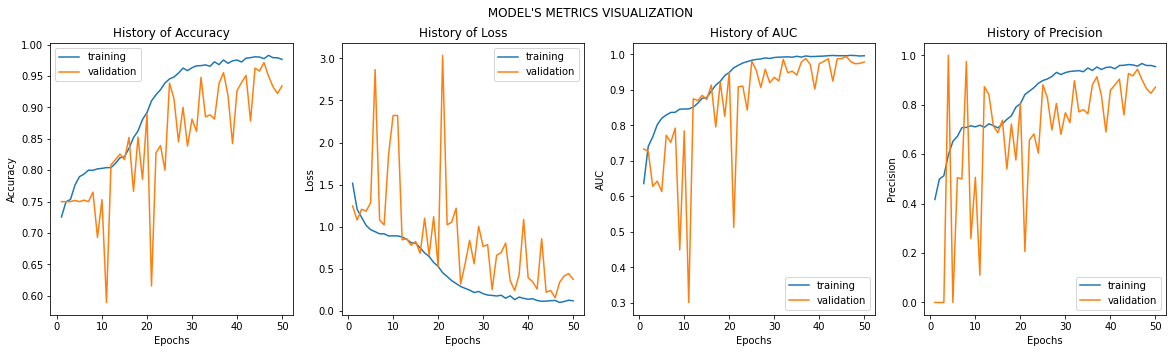

In [20]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
              model_history.history['precision'],model_history.history['val_precision']              )

In [21]:
work_dir = '/kaggle/working/'
model_dir = work_dir + "scratch_alzheimer_pre_process"
model.save(model_dir, save_format='h5')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 208, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 208, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 104, 16)       0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 52, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 26, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 13, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 13, 128)      

In [22]:
CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

    MildDemented       1.00      0.61      0.75       160
ModerateDemented       1.00      0.75      0.86        12
     NonDemented       0.81      1.00      0.90       618
VeryMildDemented       0.92      0.77      0.84       466

       micro avg       0.86      0.86      0.86      1256
       macro avg       0.93      0.78      0.84      1256
    weighted avg       0.88      0.86      0.86      1256
     samples avg       0.86      0.86      0.86      1256



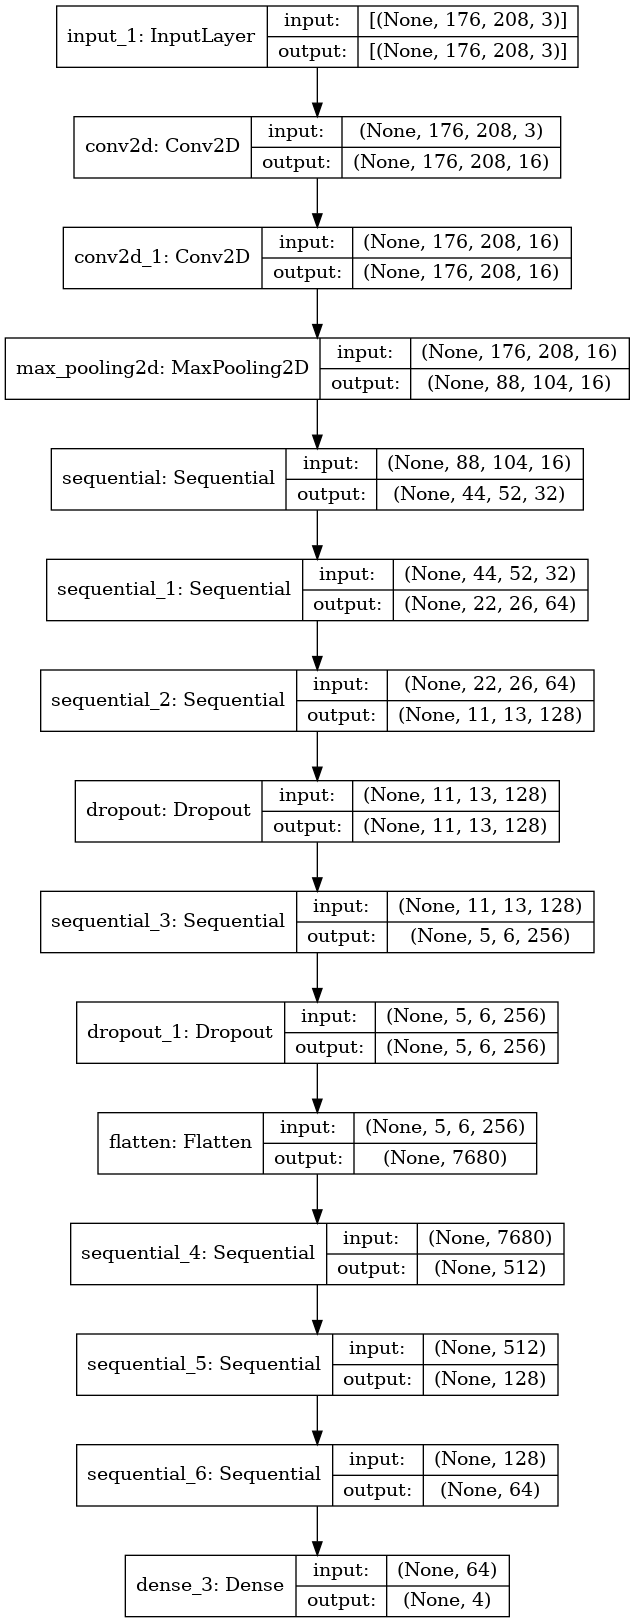

In [23]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

pretrained_model = load_model(model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)